In [1]:
from transformers import LlamaForCausalLM, LlamaTokenizer, LlamaConfig
from model import InstructGLM
from bertviz import model_view, head_view
import torch
import random
import os 
import numpy as np

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(0)
# model
model_name = '/home/zuographgroup/zhr/model/vicuna-7b-v1.5'
device = torch.device('cuda:1')
tokenizer = LlamaTokenizer.from_pretrained(model_name)
tokenizer.padding_side = 'left'
special={'additional_special_tokens': ['<Node {}>'.format(i) for i in range(1, 21)]}   # Add a new special token as place holder
tokenizer.add_special_tokens(special)
config = LlamaConfig.from_pretrained(model_name)
model = InstructGLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16, 
    config=config,
#     use_cache=True, 
#     low_cpu_mem_usage=True,
    device_map={"":device}
    )

[2024-05-09 10:23:00,553] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
import argparse
from model import GraphEncoder
from matplotlib import pyplot as plt

parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])
args.gnn_type = 'GraphSAGE'
args.gnn_output = 4096
args.num_token = 5
args.gnn_input = 128
args.gt_layers = 2
args.att_d_model = 2048
args.graph_pooling = 'sum'
args.edge_dim = None
args.dropout = 0.5
args.graph_unsup = False
args.prefix = 'graphsage_1000tp_5token_512_neg0_arxiv_linear_2_3400'
args.dataset = 'arxiv'
args.mask_token_list = None

In [3]:
# first model
first_model_path = './saved_model/first_model/{}_fm_{}_epoch{}_{}.pth'
llama_embeds = model.get_input_embeddings().weight.data
node_token=torch.zeros(110, llama_embeds.shape[1]).to(device=device, dtype=llama_embeds.dtype)
llama_embeds=torch.cat([llama_embeds, node_token],dim=0)
first_model = GraphEncoder(args, llama_embed=llama_embeds).to(device, dtype=torch.bfloat16)
first_model.load_state_dict(torch.load(first_model_path.format(args.prefix, args.dataset, 0, 'end')))

<All keys matched successfully>

In [4]:
# data
import pandas as pd
from torch_geometric.data import Data, Batch

df = pd.read_json('./instruction/pubmed/case_study.json')
add_tokens = " ".join([f"<Node {i}>" for i in range (1, 1 + 5)])
idx = 5
instruction = df.iloc[idx]
llm_out, glm_out, real_out = instruction['llm_out'], instruction['glm_out'], instruction['output']
print(llm_out, glm_out, real_out)
raw_prompt = instruction['prompt']
prompt = (raw_prompt.split('Abstract: ')[0] + 'Title: ' + raw_prompt.split('Title: ')[1])
llm_prompt = 'Given a paper with the following information:\n' + 'Title: ' + raw_prompt.split('Title: ')[1]
# llm_prompt = 'Given a paper with the following information:\n' + 'Abstract: ' + raw_prompt.split('Abstract: ')[1]
print(prompt)
print(llm_prompt)

The paper involves "Type 2 diabetes" as the subject. Experimentally induced diabetes Experimentally induced diabetes
Given a representation of a paper: <Node 1>, with the following information: 
Title: Influence of diabetes on norepinephrine-induced inositol 1,4,5-trisphosphate levels in rat aorta. 
 Question: Which diabetes does this paper involve? Please directly give the most likely answer from the following diabetes: "Type 1 diabetes", "Type 2 diabetes", "Experimentally induced diabetes".
Given a paper with the following information:
Title: Influence of diabetes on norepinephrine-induced inositol 1,4,5-trisphosphate levels in rat aorta. 
 Question: Which diabetes does this paper involve? Please directly give the most likely answer from the following diabetes: "Type 1 diabetes", "Type 2 diabetes", "Experimentally induced diabetes".


In [5]:
llama_prompt = f"""USER: {llm_prompt} ASSISTANT:"""
print(llama_prompt)
glm_prompt = f"""USER: {prompt.replace(": <Node 1>", add_tokens)} ASSISTANT:"""
print(glm_prompt)
llama_prompt_ans = f"""USER: {llm_prompt} ASSISTANT: {llm_out}"""
print(llama_prompt_ans)
glm_prompt_ans = f"""USER: {prompt.replace(": <Node 1>", add_tokens)} ASSISTANT: {glm_out}"""
print(glm_prompt_ans)

USER: Given a paper with the following information:
Title: Influence of diabetes on norepinephrine-induced inositol 1,4,5-trisphosphate levels in rat aorta. 
 Question: Which diabetes does this paper involve? Please directly give the most likely answer from the following diabetes: "Type 1 diabetes", "Type 2 diabetes", "Experimentally induced diabetes". ASSISTANT:
USER: Given a representation of a paper<Node 1> <Node 2> <Node 3> <Node 4> <Node 5>, with the following information: 
Title: Influence of diabetes on norepinephrine-induced inositol 1,4,5-trisphosphate levels in rat aorta. 
 Question: Which diabetes does this paper involve? Please directly give the most likely answer from the following diabetes: "Type 1 diabetes", "Type 2 diabetes", "Experimentally induced diabetes". ASSISTANT:
USER: Given a paper with the following information:
Title: Influence of diabetes on norepinephrine-induced inositol 1,4,5-trisphosphate levels in rat aorta. 
 Question: Which diabetes does this paper in

In [6]:
final_prompt = glm_prompt_ans + '</s>'
final_ans = glm_out
# final_prompt = glm_prompt
input_ids = tokenizer(
    final_prompt,
    return_tensors="pt"
).input_ids
print(input_ids)
attention_mask=input_ids.ne(tokenizer.pad_token_id)
targets = input_ids.clone()
target_len = len(tokenizer.tokenize(final_ans))
targets[:, :-target_len-1] = -100
print(targets)

graph = Data()
graph.edge_index = torch.LongTensor(instruction['edge_index'])
graph.edge_attr = None
node_list = instruction['node_set']
graph.x = torch.tensor(instruction['x'], dtype=torch.bfloat16)
graph.lp = False

is_node = (input_ids >= 32000)
extra_num = is_node.sum()

print(extra_num)

graph = Batch.from_data_list([graph])

tensor([[    1,  3148,  1001, 29901, 11221,   263,  8954,   310,   263,  5650,
         32000, 32001, 32002, 32003, 32004,  1919,   411,   278,  1494,  2472,
         29901, 29871,    13,  7030, 29901,   512, 25044,   663,   310,   652,
           370, 10778,   373,   302,   487, 26215, 24588,   457, 29899, 19910,
          1133,   297,   359,   277,   324, 29871, 29896, 29892, 29946, 29892,
         29945, 29899,   509,   275,   561, 25715,   403, 11174,   297,  7548,
           263,   441, 29874, 29889, 29871,    13,   894, 29901,  8449,   652,
           370, 10778,   947,   445,  5650, 25135, 29973,  3529,  4153,  2367,
           278,  1556,  5517,  1234,   515,   278,  1494,   652,   370, 10778,
         29901,   376,  1542, 29871, 29896,   652,   370, 10778,   613,   376,
          1542, 29871, 29906,   652,   370, 10778,   613,   376,  1252, 15362,
           635, 20974,   652,   370, 10778,  1642,   319,  1799,  9047, 13566,
         29901,  1222, 15362,   635, 20974,   652,  

In [ ]:
# eval
embeds = first_model(
    input_ids=input_ids.to(device),
    is_node=is_node.to(device),
    graph=graph.to(device),
    use_llm=False
)
results = model.g_step(in_embeds=embeds, attention_mask=attention_mask)
# results = model.generate(input_ids.to(device), attention_mask=attention_mask)
outputs = tokenizer.decode(results[0], skip_special_tokens=True).strip()
print(outputs)

In [7]:
# train
embeds = first_model(
    input_ids=input_ids.to(device),
    is_node=is_node.to(device),
    graph=graph.to(device),
    use_llm=False
)
output = model(inputs_embeds=embeds, labels=targets, attention_mask=attention_mask, output_attentions=True, output_hidden_states=True)
print(output['attentions'][0].shape)
print(output['hidden_states'][-1].shape)
print(output['loss'])

torch.Size([1, 32, 129, 129])
torch.Size([1, 129, 4096])
tensor(0.0688, device='cuda:1', dtype=torch.bfloat16,
       grad_fn=<NllLossBackward0>)


1222
▁Ex


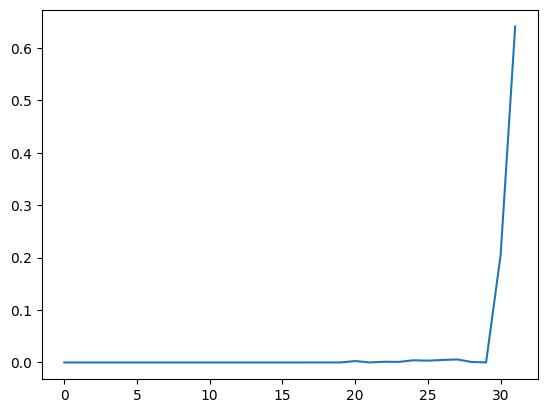

In [10]:
# logits of each layer
logits_ls = []
ans_token = tokenizer.encode(glm_out)[1]
print(ans_token)
print(tokenizer.convert_ids_to_tokens(ans_token))
for i in range(1, 33):
    layer_pred = model.lm_head(output['hidden_states'][i]).softmax(dim=-1)
    logits_ls.append(layer_pred[:, -target_len-2, ans_token].detach().cpu().to(torch.float32).numpy())
plt.plot(np.arange(32), logits_ls)
plt.show()

In [ ]:
attn = output['attentions']
tokens = tokenizer.encode(final_prompt)
tokens = tokenizer.convert_ids_to_tokens(tokens)
print(tokens)
html = head_view(attn, tokens, include_layers=[0, 31], heads=[0], html_action='return')
# html = model_view(attn, tokens, include_layers=[0, 31], html_action='return')
with open("./head_view.html", "w") as file:
    file.write(html.data)

In [ ]:
import numpy as np
from circuitsvis.attention import attention_patterns

layer_num = 30
layer_attn = output['attentions'][layer_num][0]
tokens = tokenizer.encode(final_prompt)
tokens = tokenizer.convert_ids_to_tokens(tokens)
vis_tokens = [token[1:-1] if token in add_tokens else token for token in tokens]
print(vis_tokens)
vis = attention_patterns(tokens=vis_tokens, attention=layer_attn)
vis_path = f"./llm_vis_{idx}_{layer_num}.html"
with open(vis_path, "w") as f:
    f.write(vis._repr_html_())

In [18]:
layer_num = 20
attn = output['attentions'][layer_num][0].mean(dim=0)
scale = attn.sum(dim=0)
tokens = tokenizer.encode(final_prompt)
tokens = tokenizer.convert_ids_to_tokens(tokens)
select_id = []
info_id = 0
query_id = 0
answer_id = 0
for i in range(len(tokens)):
    if tokens[i] in ['<Node 1>', '<Node 2>', '<Node 3>', '<Node 4>', '<Node 5>']:
        select_id.append(i)
    if tokens[i] == '▁Question':
        query_id = i
    elif tokens[i] == 'Title' and tokens[i-1] == '<0x0A>':
        info_id = i
    elif tokens[i] == ':' and tokens[i-1] == 'ANT':
        answer_id = i
select_attn = attn[:, select_id]
print(select_id)
print(info_id, query_id, answer_id)
# print(select_attn)

[10, 11, 12, 13, 14]
23 66 120


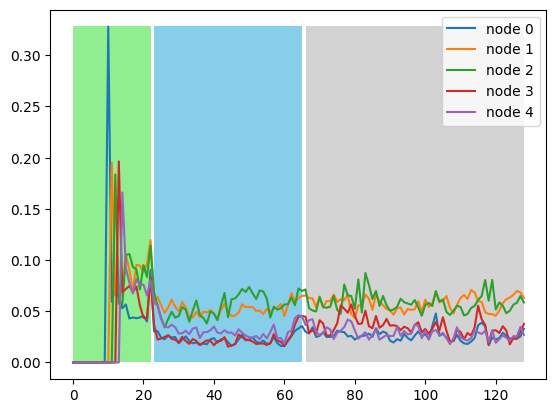

In [13]:



scale_np = scale.detach().cpu().to(torch.float32).numpy()
y = select_attn.detach().cpu().to(torch.float32).numpy()
x = np.arange(y.shape[0])
y_max = np.array([y.max() for _ in range(y.shape[0])])
for i in range(5):
    # plt.plot(x, y[:, i]/scale[select_id[i]], label=f'node {i}')
    plt.plot(x, y[:, i], label=f'node {i}')
plt.legend()
plt.fill_between(x[:info_id], y_max[:info_id], 0, facecolor = "lightgreen")
plt.fill_between(x[info_id:query_id], y_max[info_id:query_id], 0, facecolor = "skyblue")
plt.fill_between(x[query_id:], y_max[query_id:], 0, facecolor = "lightgray")
plt.show()

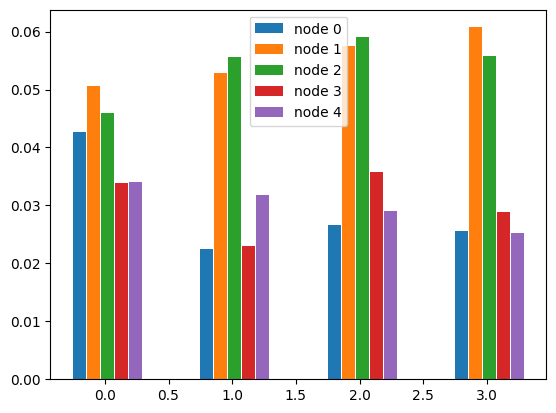

In [14]:
width = 0.1  # 柱状图的宽度，可以根据自己的需求和审美来改
offset = [- width*2, - width+0.01, 0.02, width+ 0.03, width*2 + 0.04]

for i in range(5):
    y_sq = np.array([y[:info_id, i].mean(), y[info_id:query_id, i].mean(), y[query_id:answer_id, i].mean(), y[answer_id:, i].mean()])
    # y_sq = np.array([(y[:info_id, i]/scale_np[select_id[i]]).mean(), (y[info_id:query_id, i]/scale_np[select_id[i]]).mean(),
    # (y[query_id:answer_id, i]/scale_np[select_id[i]]).mean(), (y[answer_id:, i]/scale_np[select_id[i]]).mean()])
    plt.bar(np.arange(4)+offset[i], y_sq, label=f"node {i}", width=width)
plt.legend()
plt.show()

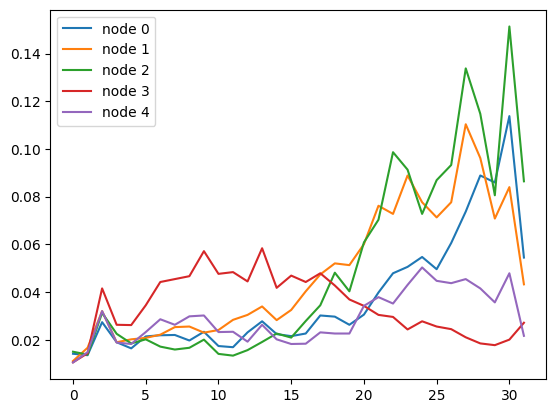

In [33]:
node_attn_ls = []
for i in range(32):
    layer_attn = output['attentions'][i][0].mean(dim=0)
    node_attn = layer_attn[:, :].sum(dim=0)
    div = layer_attn.shape[0] - torch.arrange(layer_attn.shape[0])
    node_attn = node_attn / div.to(device)
    node_attn_ls.append(node_attn)
node_attn_ls = torch.stack(node_attn_ls, dim=0).detach().cpu().to(torch.float32).numpy()
for i in range(5):
    plt.plot(np.arange(32), node_attn_ls[:, i], label=f"node {i}")
plt.legend()
plt.show()
